# Homework 4 (due 2017-11-17)
1. Implement a solver for the shallow water equations,
$$ \begin{bmatrix} h \\ h u \end{bmatrix}_t + \begin{bmatrix} hu \\ hu^2 + \frac g 2 h^2 \end{bmatrix}_x = 0 $$
where $h$ is water thickness, $hu$ is the momentum of a column of water, and $g$ is the gravitational potential.
The shallow water equations are very similar to isothermal gas dynamics except that the wave speed $c$ is not constant, but rather $\pm \sqrt{gh}$ as can be seen from the eigenvalues of the flux Jacobian.
* Choose initial conditions for your numerical experiments that create all possible configurations of subsonic and supersonic shocks and rarefactions.
* The total energy in the system is kinetic plus potential energy
$$ E = \int_{\Omega} \frac h 2 u^2 + \frac g 2 h^2 . $$
Compare the evolution of total energy using a first order method and a method using slope reconstruction, for a configuration with a shock and a configuration with only rarefactions.
* Does the result depend on your choice of Riemann solver, e.g., between HLL and Rusanov or between an exact solver and HLL?

$$ J = \begin{bmatrix} 0 & 1 \\ -u^2+gh & 2u \end{bmatrix} $$

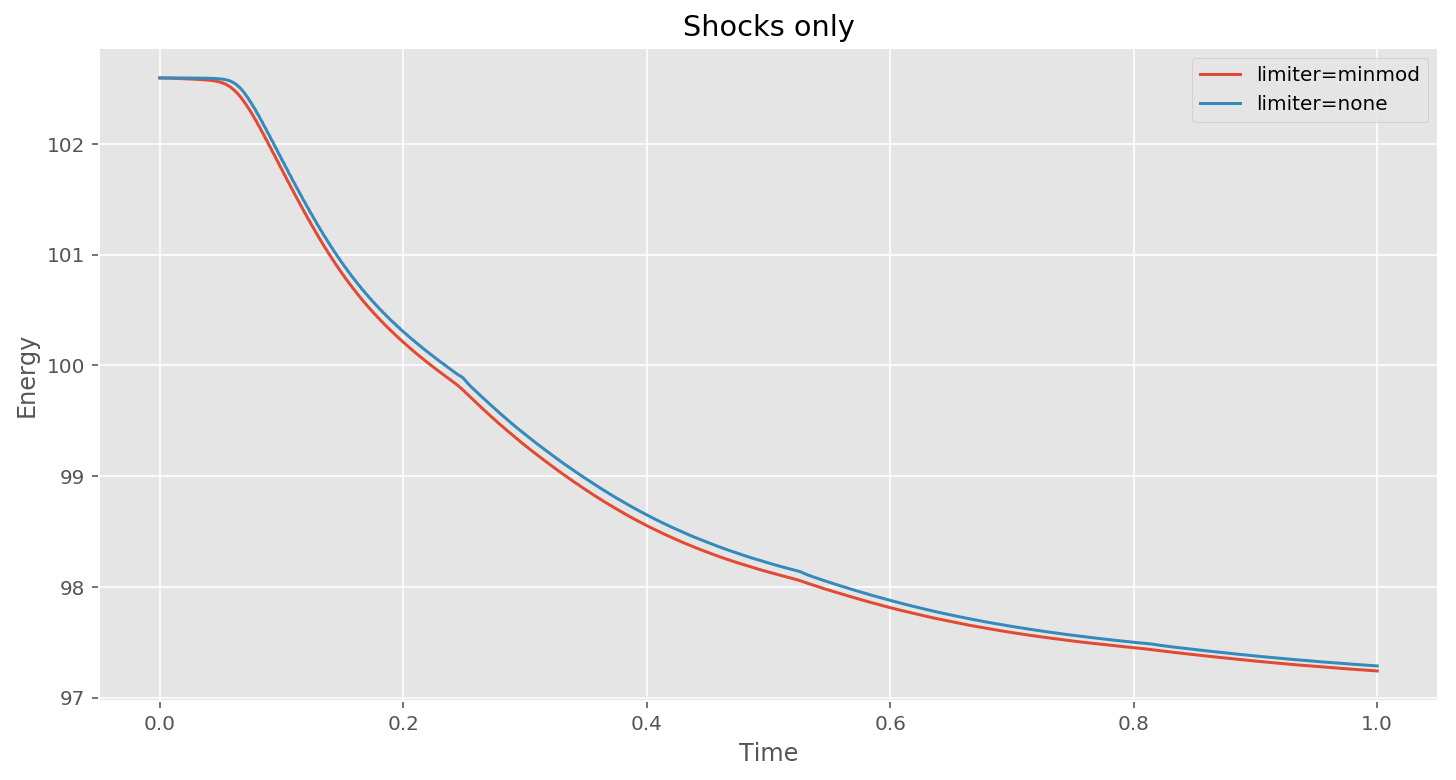

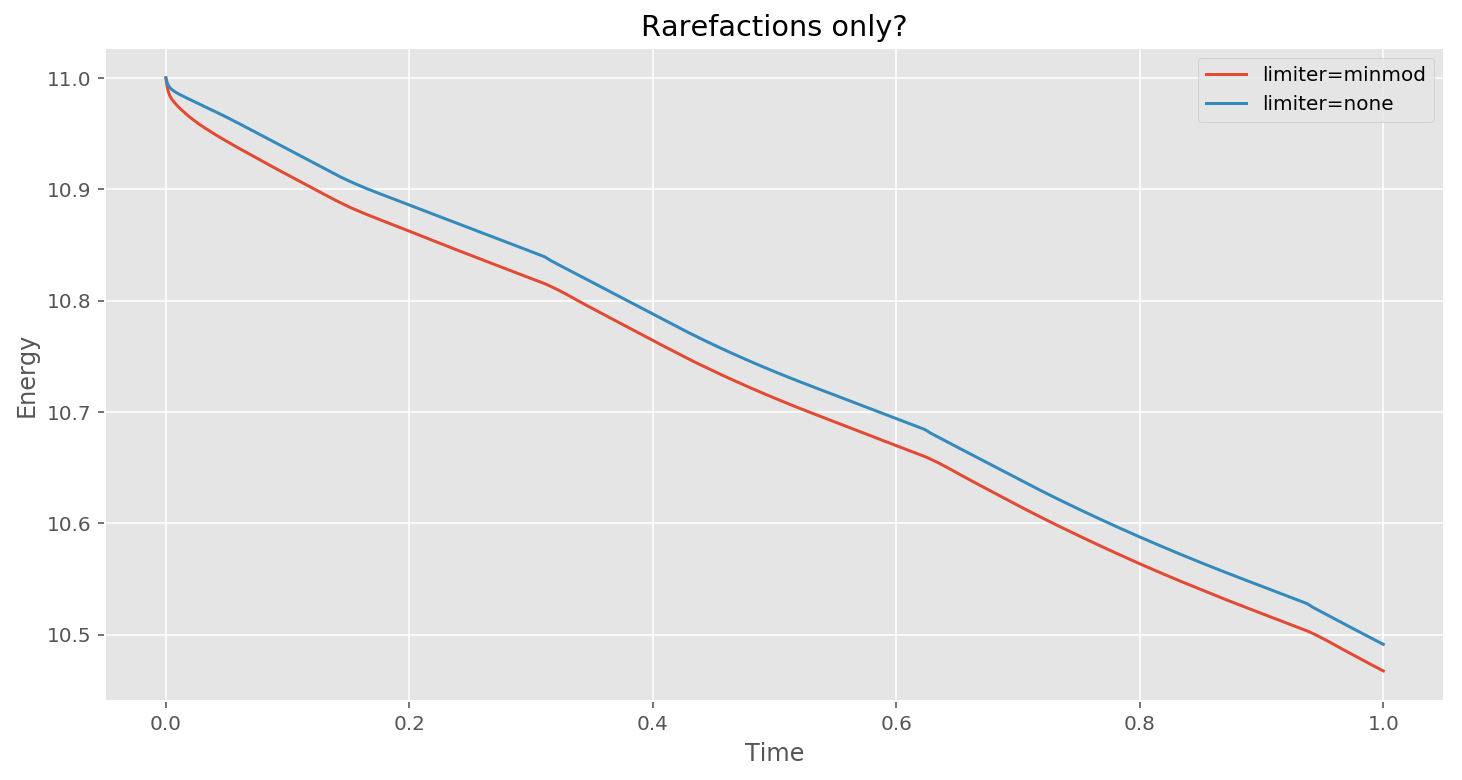

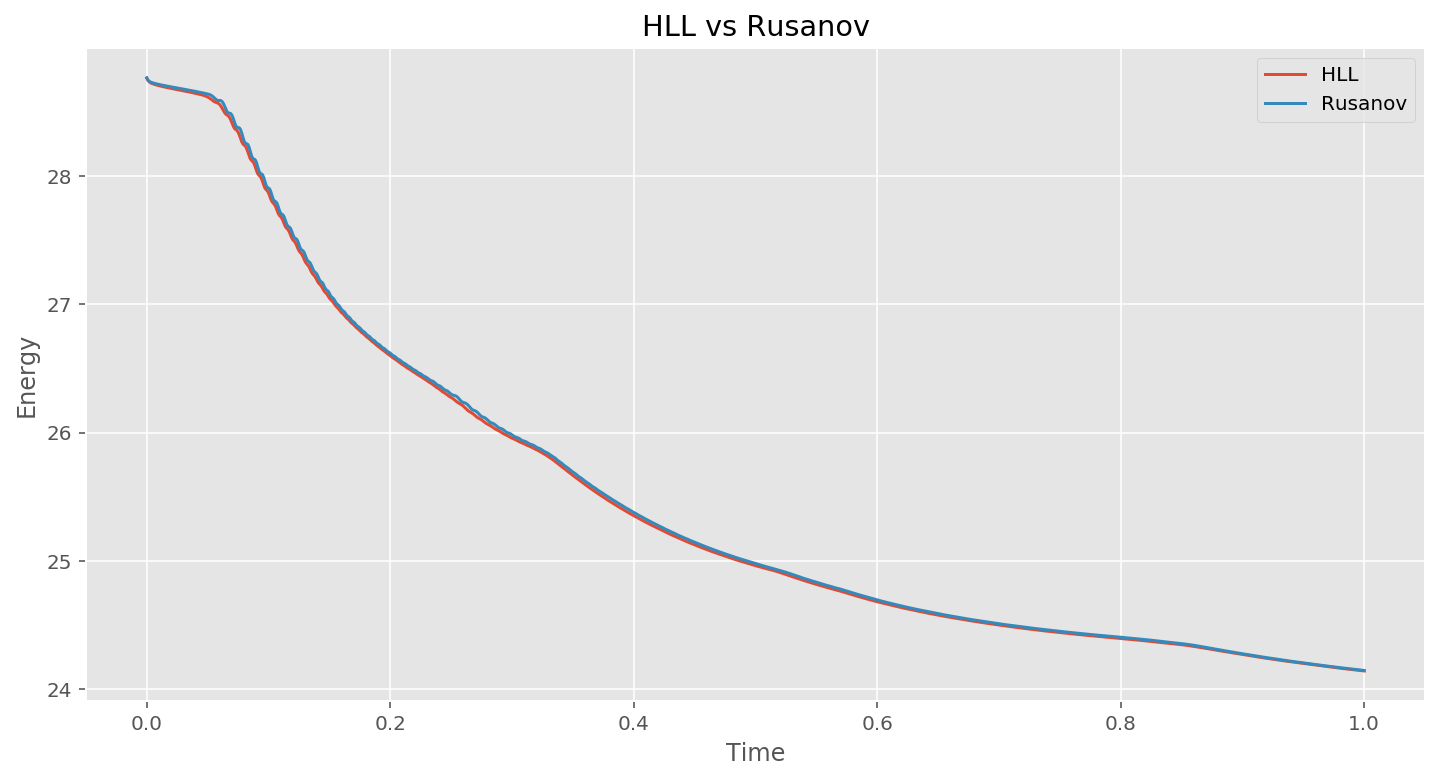

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy
from matplotlib import pyplot
import matplotlib
import matplotlib.animation as animation
%run ../fdtools.py
matplotlib.rcParams['figure.figsize'] = [12,6]
pyplot.style.use('ggplot')

limiters = []
def limappend(lim):
    limiters.append(lim)
    return lim

@limappend
def limit_zero(r):
    return 0*r

@limappend
def limit_none(r):
    return 0*r+1

@limappend
def limit_minmod(r):
    return numpy.maximum(numpy.minimum(2*r, 2*(1-r)), 0)

@limappend
def limit_sin(r):
    return numpy.where(numpy.all((0 < r, r < 1), axis=0),
                      numpy.sin(numpy.pi*r),
                      0)

@limappend
def limit_vl(r):
    return numpy.maximum(4*r*(1-r), 0)

@limappend
def limit_bj(r):
    return numpy.clip(numpy.minimum(4*r, 4*(1-r)), 0, 1)

g = 10.0

def flux_water(U):
    h = U[0]
    u = U[1] / h
    return numpy.array([U[1], U[1]*u + g/2*h**2])

def riemann_water_hll(UL, UR, rusanov=False):
    hL = UL[0]
    hR = UR[0]
    uL = UL[1] / hL
    uR = UR[1] / hR
    ghL = g * hL
    ghR = g * hR
    sL = numpy.minimum(uL - numpy.sqrt(ghL), uR - numpy.sqrt(ghR))
    sR = numpy.maximum(uL + numpy.sqrt(ghL), uR + numpy.sqrt(ghR))
    if rusanov:
        sR = numpy.maximum(numpy.abs(sL), numpy.abs(sR))
        sL = - sR
    return flux_water(numpy.where(sL > 0,
                                  UL,
                                  numpy.where(sR < 0,
                                              UR,
                                              (flux_water(UL) - flux_water(UR) - sL*UL + sR*UR) / (sR - sL))))

def initial_water_sharp_fast(x):
    return numpy.array([1 + 2*(numpy.exp(-(x*4)**2) > .5), .0 +8*(numpy.exp(-(x*4)**2) > .5)])

def initial_water_sharp(x):
    return numpy.array([1 + 2*(numpy.exp(-(x*4)**2) > .5), 0*x])

def initial_water_smooth(x):
    return numpy.array([1 + 1*(numpy.exp(-(x*4)**2)), 10 + 0*x])

def initial_water_smooth_still(x):
    return numpy.array([1 + 1*(numpy.exp(-(x*4)**2)), 0*x])

def initial_water_smooth_rarefaction(x):
    return numpy.array([1+0*x, numpy.where(x>0, 1, -1)])

def initial_water_smooth_moving(x):
    return numpy.array([1 + 1*(numpy.exp(-(x*4)**2)), 3*(numpy.exp(-(x*4)**2))+10])

def initial_water_smooth_shock(x):
    return numpy.array([1 + 1*(numpy.exp(-(x*4)**2)), -numpy.tanh(5*x)])

def initial_water_sharp_shock(x):
    return numpy.array([1 + 1*(numpy.exp(-(x*4)**2)>.5), -numpy.tanh(5*x)])

def initial_water_sharp_moving(x):
    return numpy.array([1 + 1*(numpy.exp(-(x*4)**2)>.5), 3*(numpy.exp(-(x*4)**2)+1)])

def initial_water_complex(x):
    return numpy.array([1 + 1*(numpy.exp(-(x*4+2)**2)>.5) + (numpy.exp(-(x*4-2)**2)), 1 +5*(numpy.exp(-(x*4)**2))])

def fvsolve2system(riemann, U0, a=-1, b=1, n=20, tfinal=1, limit=limit_minmod, args = ()):
    h = (b - a)/n
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    U0x = U0(x)
    Ushape = U0x.shape
    idxL = numpy.arange(-1, n-1)
    idxR = numpy.arange(1, n+1) % n
    def rhs(t, U):
        U = U.reshape(Ushape)
        jump = U[:,idxR] - U[:,idxL]
        r = numpy.zeros_like(jump)
        numpy.divide(U - U[:,idxL], jump, out=r, where=(jump!=0))
        g = limit(r) * jump / (2*h)
        fluxL = riemann(U[:,idxL] + g[:,idxL] * h/2, U - g * h/2, *args)
        return (fluxL - fluxL[:,idxR]).flatten() / h
    hist = ode_rkexplicit(rhs, U0x.flatten(), h=h/10, tfinal=tfinal)
    return x, [(t, U.reshape(Ushape)) for t, U in hist]

def system_energy(U):
    en = numpy.sum(U[1]**2/U[0]/2+g/2*U[0]**2)
    return en * 2 / len(U[0])

numpy.seterr(all='raise')


x, hist = fvsolve2system(riemann_water_hll, initial_water_smooth, n=200, limit=limit_minmod, args=(False,))
x_none, hist_none = fvsolve2system(riemann_water_hll, initial_water_smooth, n=200, limit=limit_none, args=(False,))

pyplot.figure()
pyplot.title("Shocks only")
ts = [x[0] for x in hist]
energies = [system_energy(x[1]) for x in hist]
ts_none = [x[0] for x in hist_none]
energies_none = [system_energy(x[1]) for x in hist_none]
pyplot.plot(ts, energies, label="limiter=minmod")
pyplot.plot(ts_none, energies_none, label="limiter=none")
pyplot.ylabel("Energy")
pyplot.legend()
pyplot.xlabel("Time");

x, hist = fvsolve2system(riemann_water_hll, initial_water_smooth_rarefaction, n=200, limit=limit_minmod, args=(False,))
x_none, hist_none = fvsolve2system(riemann_water_hll, initial_water_smooth_rarefaction, n=200, limit=limit_none, args=(False,))

pyplot.figure()
pyplot.title("Rarefactions only?")
ts = [x[0] for x in hist]
energies = [system_energy(x[1]) for x in hist]
ts_none = [x[0] for x in hist_none]
energies_none = [system_energy(x[1]) for x in hist_none]
pyplot.plot(ts, energies, label="limiter=minmod")
pyplot.plot(ts_none, energies_none, label="limiter=none")
pyplot.ylabel("Energy")
pyplot.legend()
pyplot.xlabel("Time");

x, hist = fvsolve2system(riemann_water_hll, initial_water_complex, n=200, args=(False,))
x_r, hist_r = fvsolve2system(riemann_water_hll, initial_water_complex, n=200, args=(True,))

pyplot.figure()
pyplot.title("HLL vs Rusanov")
ts = [x[0] for x in hist]
energies = [system_energy(x[1]) for x in hist]
ts_r = [x[0] for x in hist_r]
energies_r = [system_energy(x[1]) for x in hist_r]
pyplot.plot(ts, energies, label="HLL")
pyplot.plot(ts_r, energies_r, label="Rusanov")
pyplot.ylabel("Energy")
pyplot.legend()
pyplot.xlabel("Time");

Both plots have similar differences between limiters. I'm not sure if this is correct because I'm not sure if my rarefactions only plot actually contains only rarefactions. Rusanov appears to conserve energy a little bit better than HLL, because it has a less accurate measurement of wave speed and hence has more diffusion (which does not remove energy from the system).

In [2]:
%matplotlib auto
matplotlib.rcParams['animation.html'] = 'html5'

# from http://louistiao.me/posts/notebooks/save-matplotlib-animations-as-gifs/

fig, ax = pyplot.subplots()
pyplot.ylabel("Height")

max_h = max(map(lambda x: numpy.amax(x[1][0]), hist))
ax.set_xlim(( -1, 1))
ax.set_ylim((0, max_h+0.1))

line, = ax.plot([], [], lw=2)

def init_h():
    line.set_data([], [])
    return (line,)
def animate_h(i):
    t, U = hist[i]
    line.set_data(x, U[0])
    return (line,)

anim_h = animation.FuncAnimation(fig, animate_h, init_func=init_h,
                               frames=len(hist), interval=10000/len(hist), blit=True);

pyplot.close();
anim_h

Using matplotlib backend: MacOSX


In [3]:
%matplotlib auto
matplotlib.rcParams['animation.html'] = 'html5'
fig, ax = pyplot.subplots();
pyplot.ylabel("Velocity")

max_h = max(map(lambda x: numpy.amax(x[1][1]/x[1][0]), hist))
min_h = min(map(lambda x: numpy.amin(x[1][1]/x[1][0]), hist))
ax.set_xlim(( -1, 1))
ax.set_ylim((min_h+0.1, max_h+0.1))

line, = ax.plot([], [], lw=2);
def init_vel():
    line.set_data([], [])
    return (line,)
def animate_vel(i):
    t, U = hist[i]
    line.set_data(x, U[1]/U[0])
    return (line,)
anim = animation.FuncAnimation(fig, animate_vel, init_func=init_vel,
                               frames=len(hist), interval=10000/len(hist), blit=True);
pyplot.close();
anim

Using matplotlib backend: MacOSX
